In [1]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

engine = create_engine('sqlite:///sncf_table.sqlite')
connection = engine.connect()

Analyse Objets Perdus

In [2]:
request = """ 
    SELECT Lost_Item.date, Lost_Item.type_objets
    FROM Lost_Item 
"""

df_itemlost = pd.read_sql(request, connection, parse_dates=True)
df_itemlost['date'] = pd.to_datetime(df_itemlost['date'])
df_count = df_itemlost.groupby(pd.Grouper(key='date', freq='W-MON'))['type_objets'].agg('count').reset_index().rename(columns={'type_objets':"Nombre d'objets perdus"})
df_count

,date,Nombre d'objets perdus
0,2016-01-04 00:00:00+00:00,754
1,2016-01-11 00:00:00+00:00,1708
2,2016-01-18 00:00:00+00:00,1806
3,2016-01-25 00:00:00+00:00,1690
4,2016-02-01 00:00:00+00:00,1725
...,...,...
309,2021-12-06 00:00:00+00:00,1291
310,2021-12-13 00:00:00+00:00,1418
311,2021-12-20 00:00:00+00:00,1437
312,2021-12-27 00:00:00+00:00,1300


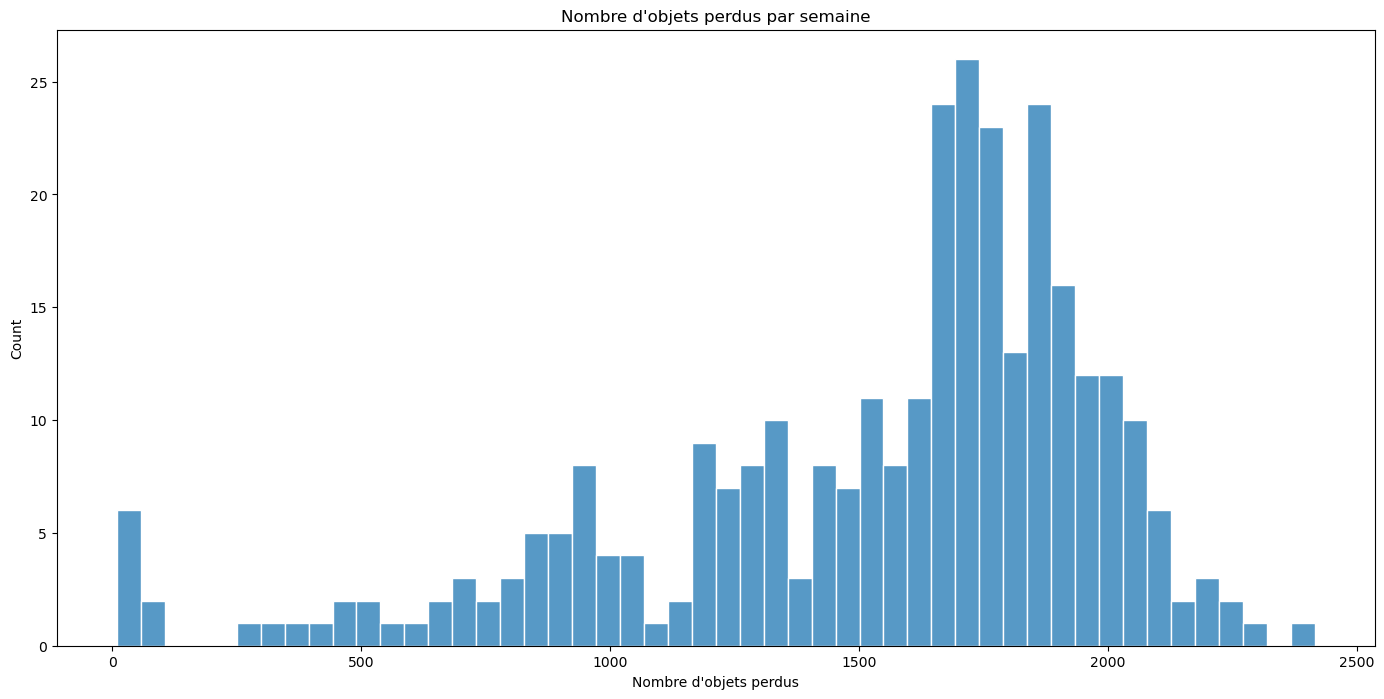

In [3]:
plt.figure(figsize=(17,8))

plt.title("Nombre d'objets perdus par semaine")
sns.set(style="darkgrid")

sns.histplot(data=df_count, x="Nombre d'objets perdus", bins=50)

plt.show()

In [4]:
fig = px.line(df_count, x="date", y="Nombre d'objets perdus",title="Evolution du nombre d'objets perdus sur la période 2016-2021")

fig.update_layout(
    xaxis_title="Année",
    yaxis_title="Nombre d'objets perdus",
    legend_title="Type d'objet",
    showlegend=True
)

fig.show()

Nombre d'objets perdus en fonction de la fréquentation de voyageur de chaque région. 

In [5]:
def trouver_region(code_departement):
    departements_par_region = {
        "Nouvelle-Aquitaine": ["16", "17", "19", "23", "24", "33", "40", "47", "64", "79", "86", "87"],
        "Auvergne-Rhône-Alpes": ["01", "03", "07", "15", "26", "38", "42", "43", "63", "69", "73", "74"],
        "Bourgogne-Franche-Comté": ["21", "25", "39", "58", "70", "71", "89", "90"],
        "Bretagne": ["22", "29", "35", "56"],
        "Centre-Val de Loire": ["18", "28", "36", "37", "41", "45"],
        "Corse": ["2A", "2B"],
        "Grand Est": ["08", "10", "51", "52", "54", "55", "57", "67", "68", "88"],
        "Hauts-de-France": ["02", "59", "60", "62", "80"],
        "Île-de-France": ["75", "77", "78", "91", "92", "93", "94", "95"],
        "Normandie": ["14", "27", "50", "61", "76"],
        "Occitanie": ["11", "12", "30", "31", "32", "34", "46", "48", "65", "66", "81", "82"],
        "Pays de la Loire": ["44", "49", "53", "72", "85"],
        "Provence-Alpes-Côte d'Azur": ["04", "05", "06", "13", "83", "84"]
    }

    # On parcourt les régions et leurs départements
    for region, departements in departements_par_region.items():
        # Si le code de département se trouve dans la liste des départements de la région,
        # on renvoie la région
        if code_departement in departements:
            return region

    # Si le code de département n'a pas été trouvé dans aucune région, on renvoie None
    return None

Total des voyageurs par année par région.

In [6]:
request = """ 
    SELECT *
    FROM Frequentation
"""

df_frequentation_region = pd.read_sql(request, connection)
df_frequentation_region = df_frequentation_region.dropna()
df_frequentation_region = df_frequentation_region.drop(columns=['code_uic'])
df_frequentation_region['code_postal']=df_frequentation_region['code_postal'].apply(lambda x : x[:2])
df_frequentation_region['code_postal']=df_frequentation_region['code_postal'].apply(trouver_region)
df_frequentation_region = df_frequentation_region.rename(columns={'code_postal':'region'})
df_frequentation_region[['total_voyageurs_2016','total_voyageurs_2017','total_voyageurs_2018','total_voyageurs_2019','total_voyageurs_2020','total_voyageurs_2021']]= df_frequentation_region[['total_voyageurs_2016','total_voyageurs_2017','total_voyageurs_2018','total_voyageurs_2019','total_voyageurs_2020','total_voyageurs_2021']].astype(int)

df_frequentation_region = df_frequentation_region.groupby(['region']).sum()

df_frequentation_region['total_voyageurs'] = df_frequentation_region[['total_voyageurs_2016','total_voyageurs_2017','total_voyageurs_2018','total_voyageurs_2019','total_voyageurs_2020','total_voyageurs_2021']].astype(int).apply(sum, axis=1)
df_frequentation_region.reset_index(inplace=True)


/tmp/ipykernel_397989/2292346949.py:14: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [7]:
df_frequentation_region = df_frequentation_region.rename(columns={'total_voyageurs_2016': '2016', 'total_voyageurs_2017': '2017', 'total_voyageurs_2018': '2018', 
'total_voyageurs_2019': '2019', 'total_voyageurs_2020': '2020','total_voyageurs_2021': '2021'})
df_frequentation_region

,region,2016,2017,2018,2019,2020,2021,total_voyageurs
0,Auvergne-Rhône-Alpes,114531857,122725533,114936549,126146029,79025024,102080302,659445294
1,Bourgogne-Franche-Comté,29731113,31149745,28285174,30762928,21979560,26121567,168030087
2,Bretagne,27728704,29357842,28989810,32416291,22037678,28665328,169195653
3,Centre-Val de Loire,36469734,37394263,35556304,37501895,24632758,31914984,203469938
4,Grand Est,96476641,101381275,98175146,104924979,69256659,84281183,554495883
5,Hauts-de-France,108263780,115196838,108220085,117372829,73484876,88143893,610682301
6,Normandie,28869494,30412489,28032003,30955473,19298385,24142494,161710338
7,Nouvelle-Aquitaine,53830690,59736728,58210973,65044031,42398258,58555528,337776208
8,Occitanie,55343564,58231960,49971368,53497884,39384780,52999766,309429322
9,Pays de la Loire,36868937,38933202,37601833,39976695,24296462,32559057,210236186


In [8]:
df_melted = df_frequentation_region.melt(id_vars='region', value_vars=['2016','2017','2018','2019','2020','2021'], var_name='annee', value_name='nombre_voyageurs')
df_melted.sort_values(by=['region','annee'], ascending=[True,True])
df_melted.reset_index()
df_melted

,region,annee,nombre_voyageurs
0,Auvergne-Rhône-Alpes,2016,114531857
1,Bourgogne-Franche-Comté,2016,29731113
2,Bretagne,2016,27728704
3,Centre-Val de Loire,2016,36469734
4,Grand Est,2016,96476641
...,...,...,...
67,Nouvelle-Aquitaine,2021,58555528
68,Occitanie,2021,52999766
69,Pays de la Loire,2021,32559057
70,Provence-Alpes-Côte d'Azur,2021,38522098


Nombre d'objets perdus par code_uic et par année.

In [9]:
request = """ 
    SELECT Lost_Item.date, Lost_Item.type_objets, Lost_item.code_uic
    FROM Lost_Item 
"""

df_itemlost_annee = pd.read_sql(request, connection)
df_itemlost_annee['date'] = df_itemlost_annee['date'].apply(lambda x : x[:4])
df_itemlost_annee = df_itemlost_annee.rename(columns={'date':'annee'})
df_itemlost_annee = df_itemlost_annee.groupby(['code_uic','annee']).count().rename(columns={"type_objets":"nombre d'objets perdus"})
df_itemlost_annee.reset_index(inplace=True)
df_itemlost_annee


,code_uic,annee,nombre d'objets perdus
0,0087111849,2016,644
1,0087111849,2017,553
2,0087111849,2018,320
3,0087111849,2019,291
4,0087111849,2020,99
...,...,...,...
935,0087784009,2018,578
936,0087784009,2019,530
937,0087784009,2020,408
938,0087784009,2021,562


Lien entre la gare et sa région.

In [10]:
request = """ 
    SELECT Gare.code_uic, Gare.code_postal
    FROM Gare
"""

df_gare_region = pd.read_sql(request, connection)
df_gare_region = df_gare_region.dropna()
df_gare_region['code_postal']=df_gare_region['code_postal'].apply(lambda x : x[:2])
df_gare_region['code_postal']=df_gare_region['code_postal'].apply(trouver_region)
df_gare_region = df_gare_region.rename(columns={'code_postal':'region'})
df_gare_region

,code_uic,region
0,0087784868,Occitanie
1,0087784850,Occitanie
2,0087784843,Occitanie
3,0087784777,Occitanie
4,0087784769,Occitanie
...,...,...
3185,0087113514,Île-de-France
3186,0087485060,Nouvelle-Aquitaine
3187,0087700146,Bourgogne-Franche-Comté
3211,0087184408,Bourgogne-Franche-Comté


In [11]:
df_merged_gare_objets = pd.merge(df_itemlost_annee,df_gare_region, on='code_uic', how='inner')
df_merged_gare_objets

,code_uic,annee,nombre d'objets perdus,region
0,0087111849,2016,644,Île-de-France
1,0087111849,2017,553,Île-de-France
2,0087111849,2018,320,Île-de-France
3,0087111849,2019,291,Île-de-France
4,0087111849,2020,99,Île-de-France
...,...,...,...,...
941,0087784009,2018,578,Occitanie
942,0087784009,2019,530,Occitanie
943,0087784009,2020,408,Occitanie
944,0087784009,2021,562,Occitanie


Nombre d'objets perdus par année et par région.

In [12]:
df_merged = df_itemlost_annee.merge(df_merged_gare_objets, on='code_uic')
df_merged['region'].rename('code_uic')
df_itemlost_annee['code_uic'].update(df_merged['region'])
df_itemlost_annee = df_itemlost_annee.rename(columns={'code_uic':'region'})
df_itemlost_annee

,region,annee,nombre d'objets perdus
0,Île-de-France,2016,644
1,Île-de-France,2017,553
2,Île-de-France,2018,320
3,Île-de-France,2019,291
4,Île-de-France,2020,99
...,...,...,...
935,Hauts-de-France,2018,578
936,Hauts-de-France,2019,530
937,Hauts-de-France,2020,408
938,Hauts-de-France,2021,562


Fusion de deux tables pour obtenir une table avec le nombres d'objets perdus et la fréquentation par région et par année.

In [13]:
df_merged = df_itemlost_annee.merge(df_melted, on=['region','annee'])
df_merged

,region,annee,nombre d'objets perdus,nombre_voyageurs
0,Île-de-France,2016,644,2045289373
1,Île-de-France,2016,2336,2045289373
2,Île-de-France,2016,121,2045289373
3,Île-de-France,2016,959,2045289373
4,Île-de-France,2016,28,2045289373
...,...,...,...,...
935,Hauts-de-France,2018,1796,108220085
936,Hauts-de-France,2018,268,108220085
937,Hauts-de-France,2018,260,108220085
938,Hauts-de-France,2018,203,108220085


In [15]:
def afficher_carte(year,type):
       #filtrer les données par année et type
       df_filtre = df.loc[(df["date"].str.contains(year)) & (df["objet"] == type)]
       #ajouter le nombre d'objets a la table gare
   
   
       df_filtre_gare = df_filtre.groupby("region")["objet"].count().reset_index()
       #st.dataframe(df_filtre_gare)
       
       
       df_filtre_gare = pd.merge(gare_df,df_filtre_gare,left_on="region",right_on="region").drop_duplicates(['region'])
       #df_filtre_gare = pd.merge(gare_df,df_filtre_gare,on=['region','code_uic']).drop_duplicates(['region','code_uic'])
       anciennes_regions = {"REGION BOURGOGNE FRANCHE-COMTE": "Bourgogne-Franche-Comté",
                       "REGION CENTRE" : "Centre-Val de Loire",
                       "REGION CHAMPAGNE-ARDENNE": "Grand Est",
                       "REGION LORRAINE": "Grand Est",
                       "REGION ALSACE":"Grand Est",
                       "REGION PICARDIE": "Hauts-de-France",
                       "REGION NORD PAS DE CALAIS": "Hauts-de-France",
                       "REGION DE PARIS RIVE GAUCHE": "\u00cele-de-France",
                       "REGION DE PARIS SAINT-LAZARE": "\u00cele-de-France",
                       "REGION DE PARIS-EST": "\u00cele-de-France",
                       "REGION DE PARIS-NORD":"\u00cele-de-France",
                       "REGION DE PARIS-SUD-EST":"\u00cele-de-France",
                       "REGION NORMANDIE": "Normandie",
                       "REGION POITOU-CHARENTES AQUITAINE": "Nouvelle-Aquitaine",
                       "REGION LIMOUSIN":"Nouvelle-Aquitaine",
                       "REGION LANGUEDOC-ROUSSILLON": "Occitanie",
                       "REGION MIDI PYRENEES":"Occitanie",
                       "REGION PAYS DE LA LOIRE": "Pays de la Loire",
                       "REGION PROVENCE ALPES COTE D'AZUR": "Provence-Alpes-Côte d'Azur",
                       "REGION ALPES": "Provence-Alpes-Côte d'Azur",
                       "REGION AUVERGNE": "Auvergne-Rhône-Alpes",
                       "REGION RHONE-ALPES": "Auvergne-Rhône-Alpes",
                       "REGION BRETAGNE":"Bretagne"
                       }
   
       df_filtre_gare = df_filtre_gare.replace(anciennes_regions)
       #st.dataframe(df_filtre_gare)
       df_filtre_voy = frequ_df[["code_uic","nbVoyageur"+str(year)]]
       df_filtre_final = pd.merge(df_filtre_gare,df_filtre_voy,on="code_uic")
       df_filtre_final = df_filtre_gare.groupby("region")["objet"].sum().reset_index()
       #st.dataframe(df_filtre_gare)
       #ajouter le nombre de voyageur a la table gare
       #st.dataframe(df_filtre_final)
       #dfFinal =pd.concat([df_filtre_final,df_filtre_voy])
       #st.dataframe(dfFinal)
       #créer la carte
       carte = folium.Map(location=[46.227638,2.213749], zoom_start=6)
       folium.Choropleth(geo_data="regions.geojson",
                       data=df_filtre_final,
                       columns=["region","objet","nbVoyageur"],
                       key_on="feature.properties.nom",
                       fill_color="YlGn",
                       legend_name="Nombre d'objets perdus en {} par rapport à la fréquentation des voyageurs en {}".format(type,year)).add_to(carte)
       
   
       return carte 
   #créer les widgets
   year = st.selectbox("Choisissez l'année : ",["2016","2017","2018","2019","2020","2021"])
   type = st.selectbox("Choisissez le type d'objet : ",listTypeObjet)
   #afficher la carte
   stf.st_folium(afficher_carte(year,type))

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 60)